# Image Week - Day 1 - Exercise 3 - Variational methods for Image Restoration

<a target="_blank" href="https://colab.research.google.com/github/leclairearthur/imageweek/blob/main/exo3.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

<br/><br/>

In this practical session, you have to complete the code regions marked ``### ... ###``.

In [142]:
import numpy as np
from torch.fft import fft2, ifft2, fftshift, ifftshift
import matplotlib.pyplot as plt
import torch
print(torch.__version__)

pi = torch.pi

def rgb2gray(u):
    return 0.2989 * u[:,:,0] + 0.5870 * u[:,:,1] + 0.1140 * u[:,:,2]

def str2(chars):
    return "{:.2f}".format(chars)

def psnr(uref,ut,M=1):
    mse = np.sqrt(np.mean((np.array(uref)-np.array(ut))**2))
    return 20*np.log10(M/mse)

def optim(f,niter=1000,lr=0.1):
    u = torch.randn(M,N, requires_grad=True)
    optimu = torch.optim.SGD([u], lr=lr)
    losslist = []
    for it in range(niter):
        loss = f(u)
        losslist.append(loss.detach())
        optimu.zero_grad()
        loss.backward()
        optimu.step()
    return u.detach(),losslist

# viewimage
import tempfile
import IPython
from skimage.transform import rescale

def viewimage(im, normalize=True,z=2,order=0,titre='',displayfilename=False):
    imin= np.array(im).copy().astype(np.float32)
    imin = rescale(imin, z, order=order)
    if normalize:
        imin-=imin.min()
        if imin.max()>0:
            imin/=imin.max()
    else:
        imin=imin.clip(0,255)/255 
    imin=(imin*255).astype(np.uint8)
    filename=tempfile.mktemp(titre+'.png')
    if displayfilename:
        print (filename)
    plt.imsave(filename, imin, cmap='gray')
    IPython.display.display(IPython.display.Image(filename))

# alternative viewimage if the other one does not work:
def Viewimage(im,dpi=100,cmap='gray'):
    plt.figure(dpi=dpi)
    if cmap is None:
        plt.imshow(np.array(im))
    else:
        plt.imshow(np.array(im),cmap=cmap)
    plt.axis('off')
    plt.show()
    
"""!wget https://perso.telecom-paristech.fr/aleclaire/mva/tpdeblur.zip
!unzip tpdeblur.zip"""

2.2.0+cpu


'!wget https://perso.telecom-paristech.fr/aleclaire/mva/tpdeblur.zip\n!unzip tpdeblur.zip'

# A) Deblurring with Tychonov and $\mathsf{TV}_\varepsilon$ regularizations

<br/>In this practical session, you have to fill the code at places marked ``### ... ###``

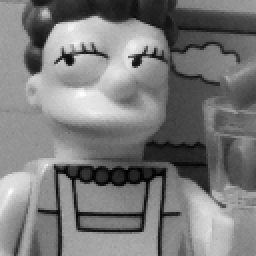

In [143]:
# Open the image
u0 = torch.tensor(rgb2gray(plt.imread('im/simpson512crop.png')))
M,N = u0.shape

viewimage(u0)

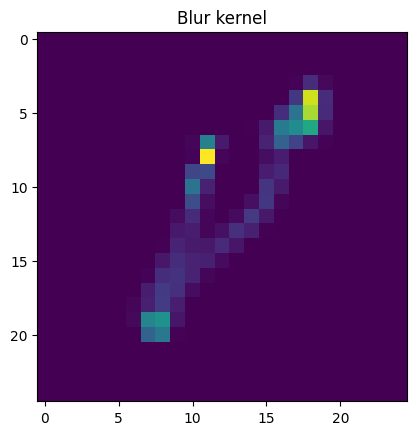

In [144]:
# Load a blur kernel
kt = torch.tensor(np.loadtxt('kernels/kernel8.txt'))
# kt = np.loadtxt('kernels/levin7.txt')
(m,n) = kt.shape

plt.imshow(kt)
plt.title('Blur kernel')
plt.show()

# Embed the kernel in a MxN image, and put center at pixel (0,0)
k = torch.zeros((M,N))
k[0:m,0:n] = kt/torch.sum(kt)
k = torch.roll(k,(-int(m/2),-int(n/2)),(0,1))
fk = fft2(k)

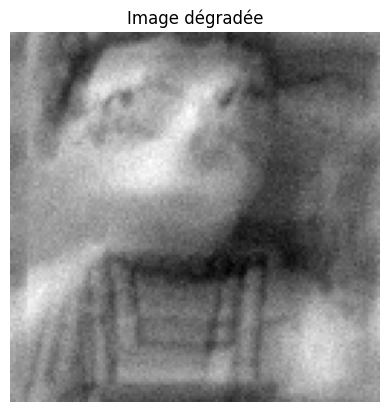

In [145]:
# Compute the degraded image v = k*u0 + w  (convolution with periodic boundary conditions)
sigma = 0.02
v = ifft2(fft2(u0)*fk).real + sigma*torch.randn(M,N)


plt.figure(dpi=100)
plt.imshow(v,cmap='gray')
plt.title('Image dégradée')
plt.axis('off')
plt.show()

## Deblurring with Tychonov regularization

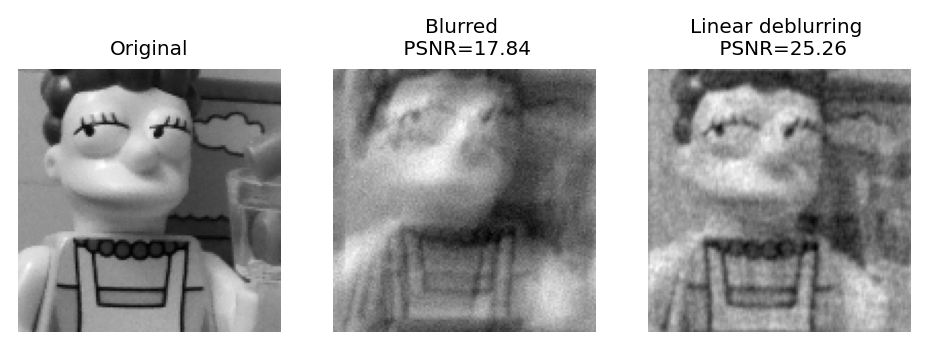

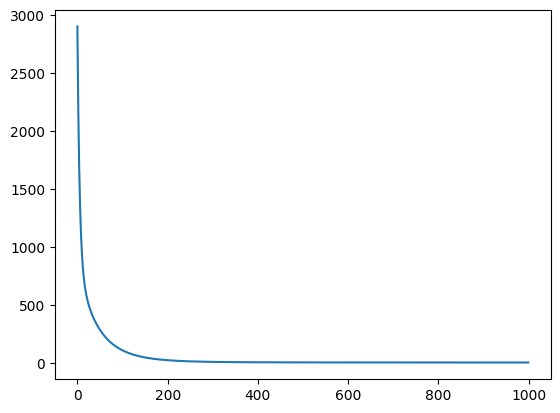

In [148]:
# Write the functional with data-fidelity and regularization with weight lam>0.
# On se sert de ||grad(u)||² = ||d1u||² + ||d2u||² 

def Ft(u, lam=1):
    ku = ifft2(fft2(k)*fft2(u)).real
    data_fid = (1/2)*(torch.sum((ku-v)**2))
    d1u = torch.roll(u, -1, 0) - u
    d2u = torch.roll(u, -1, 1) - u
    reg = lam*(torch.sum((d1u)**2) + torch.sum((d2u)**2))
    return(data_fid + reg)

lam = 0.01
tau = 2/(1+16*lam)

F = lambda u : Ft(u,lam)
u,losslist = optim(F)
utych = u

plt.figure(dpi=180)
plt.subplot(1,3,1)
plt.imshow(u0, cmap='gray')
plt.title('Original',fontsize=8)
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(v, cmap='gray')
plt.title('Blurred \n PSNR='+str2(psnr(u0,v)),fontsize=8)
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(u, cmap='gray')
plt.title('Linear deblurring \n PSNR='+str2(psnr(u0,u)),fontsize=8)
plt.axis('off')
plt.show()

plt.figure(dpi=100)
plt.plot(losslist)
plt.show()

Final error =  tensor(0.0021)


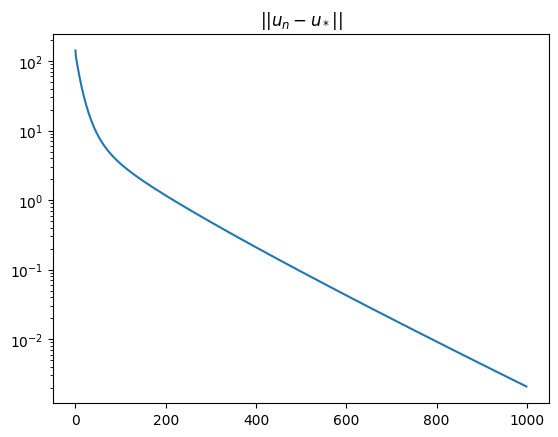

In [149]:
# Compare with explicit computation of Tychonov denoising (by plotting |u_n - u_*|)

lam = 0.01
tau = 1/(1+16*lam) # Valeur max : 2/(1+16*lam)

xi = torch.arange(M)
ind = (xi>M/2)
xi[ind] = xi[ind]-M
zeta = torch.arange(N)
ind = (zeta>N/2)
zeta[ind] = zeta[ind]-N
Xi,Zeta = torch.meshgrid(xi,zeta)
fk = fft2(k)
fh = torch.conj(fk)/(torch.abs(fk)**2+2*lam*4*(torch.sin(pi*Xi/M)**2 + torch.sin(pi*Zeta/N)**2))

us = ifft2(fft2(v)*fh).real

u = torch.randn(M,N, requires_grad=True)
optimu = torch.optim.SGD([u], tau)
losslist = []
for it in range(1000):
    loss = F(u)
    losslist.append(torch.sqrt(torch.sum((u.detach()-us)**2)))
    optimu.zero_grad()
    loss.backward()
    optimu.step()

uf = u.detach()


print('Final error = ',torch.sqrt(torch.sum((uf-us)**2)))
    
plt.figure(dpi=100)
plt.semilogy(losslist)
plt.title('$||u_n-u_*||$')
plt.show()

## Deblurring with smoothed total variation

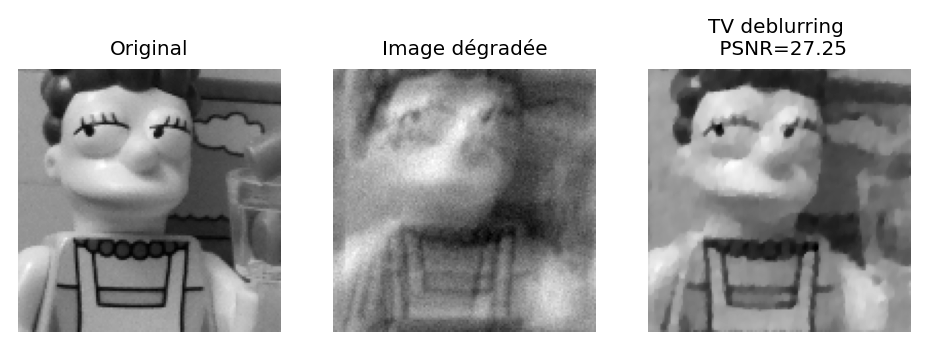

In [153]:
# Write the functional with data-fidelity and regularization with weight lam>0.
def Gt(u, lam=1, ep=0.01):
    ku = ifft2(fft2(k)*fft2(u)).real
    data_fid = (1/2)*(torch.sum((ku-v)**2))
    d1u = torch.roll(u, -1, 0) - u
    d2u = torch.roll(u, -1, 1) - u
    reg = lam*torch.sum(torch.sqrt(ep**2 +  (d1u)**2 + (d2u)**2))
    return(data_fid + reg)


lam = 0.004
ep = 0.01

tau = 1/(1+8*lam/ep) # Valeur max : 2/(1+8*lam/ep)

G = lambda u : Gt(u,lam)
u,losslist = optim(G, 1000, tau)
utvs = u

plt.figure(dpi=180)
plt.subplot(1,3,1)
plt.imshow(u0, cmap='gray')
plt.title('Original',fontsize=8)
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(v, cmap='gray')
plt.title('Image dégradée',fontsize=8)
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(u, cmap='gray')
plt.title('TV deblurring \n PSNR='+str2(psnr(u0,u)),fontsize=8)
plt.axis('off')
plt.show()

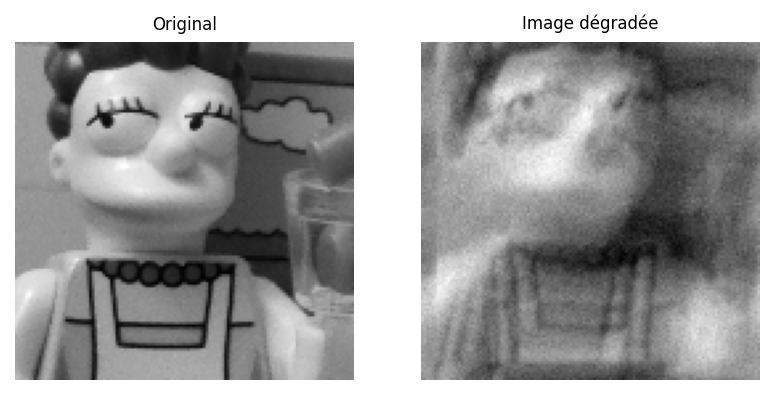

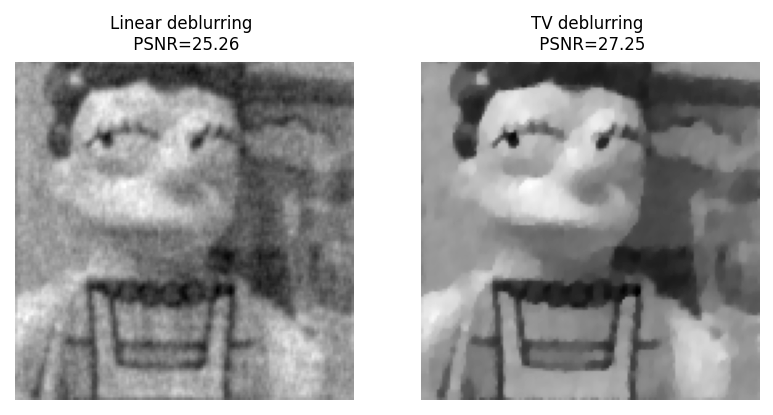

In [154]:
# Compare deblurring results with Tychonov regularization and TV regularization

plt.figure(dpi=150)
plt.subplot(1,2,1)
plt.imshow(u0, cmap='gray')
plt.title('Original',fontsize=8)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(v, cmap='gray')
plt.title('Image dégradée',fontsize=8)
plt.axis('off')
plt.show()

plt.figure(dpi=150)
plt.subplot(1,2,1)
plt.imshow(utych, cmap='gray')
plt.title('Linear deblurring \n PSNR='+str2(psnr(u0,utych)),fontsize=8)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(utvs, cmap='gray')
plt.title('TV deblurring \n PSNR='+str2(psnr(u0,utvs)),fontsize=8)
plt.axis('off')
plt.show()

## Adjusting the regularization parameter

In [122]:
# Find the value of the regularization parameter lambda that optimizes the PSNR
# Do it first for Tychonov regularization, and then for smoothed TV.
# Compare the final restoration results obtained with these oracle values of lambda.

### ... ###

## Repeat the exercise with a Gaussian blur kernel

In [123]:
### ... ###

<br/><br/><br/><br/><br/>

# B) Inpainting with $\mathsf{TV}_{\varepsilon}$ regularization

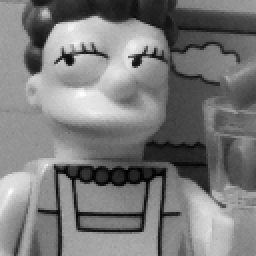

In [124]:
# Open the image
u0 = torch.tensor(rgb2gray(plt.imread('im/simpson512crop.png')))
M,N = u0.shape

viewimage(u0)

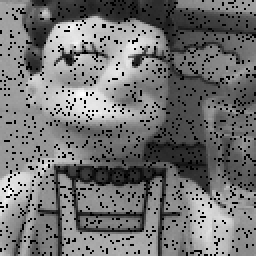

In [157]:
# Generate a random mask with proportion p of masked pixels
p = .9
mask = (torch.rand(M,N)<p)*1.
# other choice:
#mask = torch.ones(M,N)
#mask[:,60:65] = 0

v = u0*mask

viewimage(v)

## Relaxed Inpainting

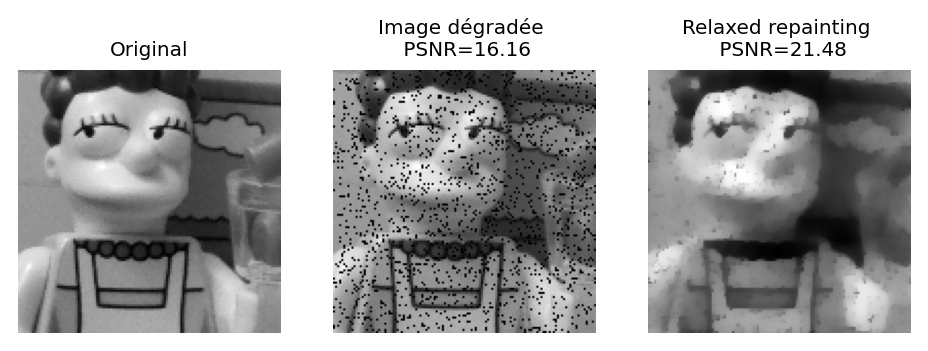

In [170]:
# Perform relaxed TV inpainting by minimizing 1/2 |u-v|^2 + tv_ep(u)

def Ht(u, lam=1, ep=0.01):
    data_fid = (1/2)*(torch.sum((u-v)**2))
    d1u = torch.roll(u, -1, 0) - u
    d2u = torch.roll(u, -1, 1) - u
    reg = lam*torch.sum(torch.sqrt(ep**2 +  (d1u)**2 + (d2u)**2))
    return(data_fid + reg)


lam = 0.2
ep = 0.01

tau = 1/(1+8*lam/ep) # Valeur max : 2/(1+8*lam/ep)

H = lambda u : Ht(u,lam)
u,losslist = optim(H, 2000, tau)

plt.figure(dpi=180)
plt.subplot(1,3,1)
plt.imshow(u0, cmap='gray')
plt.title('Original',fontsize=8)
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(v, cmap='gray')
plt.title('Image dégradée \n PSNR='+str2(psnr(u0,v)),fontsize=8)
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(u, cmap='gray')
plt.title('Relaxed repainting \n PSNR='+str2(psnr(u0,u)),fontsize=8)
plt.axis('off')
plt.show()

## Constrained Inpainting (with Projected Gradient Descent)

In [ ]:
# Perform constrained TV inpainting by minimizing tv_ep(u) with constraint u = v outside the mask

### ... ###

<br/><br/><br/><br/><br/>

## C) Super-resolution

In [ ]:
# Adjust the framework to address super-resolution with smoothed TV
# For anti-aliasing, you may use the Butterworth filter of order n and cut-off frequency fc 
#   given below

fc = .45  # cutoff frequency
n=20      # order of the filter

bf = 1/torch.sqrt(1+(f/fc)**(2*n))

xi = torch.arange(M)
ind = (xi>M/2)
xi[ind] = xi[ind]-M
zeta = torch.arange(N)
ind = (zeta>N/2)
zeta[ind] = zeta[ind]-N
Xi,Zeta = torch.meshgrid(xi,zeta,indexing='ij')

bf1 = 1/torch.sqrt(1+(Xi/(M*fc/2))**(2*n))
bf2 = 1/torch.sqrt(1+(Zeta/(N*fc/2))**(2*n))
bf = bf1*bf2

viewimage(bf)

plt.figure(dpi=100)
plt.plot(bf[0,:])
plt.show()

In [ ]:
### ... ###

In [ ]:
# Adjust your code to that it can handle color images

### ... ###

<br/><br/><br/><br/><br/>

## D) Deblurring with non-periodic boundary conditions

In [ ]:
# Adjust the deblurring code so that the blur operator is implemented without boundary conditions.
# -> After the convolution operator by the (2s+1)x(2s+1) kernel, you cut a s border on each side.

### ... ###

For an image of size (N,M) :

2D-DFT $((x(n,m))_{0 \leq n \leq N-1, 0 \leq m \leq M-1}) (k,l) = X(k,l) = \sum_{m=0}^{M-1}(\sum_{n=0}^{N-1} x(n,m) e^{\frac{-2i\pi k n}{N}})e^{\frac{-2i\pi l m}{M}}$

